In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

In [3]:

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform, loguniform

In [4]:
from lifelines import KaplanMeierFitter

In [5]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.tree import SurvivalTree
from sksurv.meta import Stacking
from sksurv.linear_model import CoxPHSurvivalAnalysis

## Import dataset

In [6]:
# Import dataset
df = pd.read_csv('dataset_da_2017.csv', encoding='utf-8')
print(df.head())

   Patient ID  Year of diagnosis     Sex  Age   Race Median household income  \
0        3614               2017  Female   74  White               ≥ $75,000   
1        4135               2017  Female   78  White               ≥ $75,000   
2        4432               2017  Female   69  White               ≥ $75,000   
3        7922               2017  Female   79  White               ≥ $75,000   
4       66852               2017  Female   81  White               ≥ $75,000   

      Marital status at diagnosis    Grade Combined Summary Stage Stage Group  \
0  Married (including common law)      III                Distant          IV   
1                         Widowed  Unknown                Distant          IV   
2                        Divorced  Unknown                Distant          IV   
3                        Divorced       II               Regional          II   
4  Married (including common law)      III               Regional         III   

   ... Surgery Radiation Chemoth

In [7]:
# Drop some unuseful columns
columns_to_drop = ['Patient ID', 'Year of diagnosis', 'Survival months flag']
df = df.drop(columns=columns_to_drop)
print(df.head())
print(df.shape)

      Sex  Age   Race Median household income     Marital status at diagnosis  \
0  Female   74  White               ≥ $75,000  Married (including common law)   
1  Female   78  White               ≥ $75,000                         Widowed   
2  Female   69  White               ≥ $75,000                        Divorced   
3  Female   79  White               ≥ $75,000                        Divorced   
4  Female   81  White               ≥ $75,000  Married (including common law)   

     Grade Combined Summary Stage Stage Group Tumor Size Surgery Radiation  \
0      III                Distant          IV         50      No   Unknown   
1  Unknown                Distant          IV         56      No   Unknown   
2  Unknown                Distant          IV         66      No   Unknown   
3       II               Regional          II         23     Yes   Unknown   
4      III               Regional         III         68      No       Yes   

  Chemotherapy Mets at DX-bone Mets at DX-br

In [8]:
# Replace the unknown values with NaNs
df.replace("Unknown", np.nan, inplace=True)
print(df.head())

      Sex  Age   Race Median household income     Marital status at diagnosis  \
0  Female   74  White               ≥ $75,000  Married (including common law)   
1  Female   78  White               ≥ $75,000                         Widowed   
2  Female   69  White               ≥ $75,000                        Divorced   
3  Female   79  White               ≥ $75,000                        Divorced   
4  Female   81  White               ≥ $75,000  Married (including common law)   

  Grade Combined Summary Stage Stage Group Tumor Size Surgery Radiation  \
0   III                Distant          IV         50      No       NaN   
1   NaN                Distant          IV         56      No       NaN   
2   NaN                Distant          IV         66      No       NaN   
3    II               Regional          II         23     Yes       NaN   
4   III               Regional         III         68      No       Yes   

  Chemotherapy Mets at DX-bone Mets at DX-brain Mets at DX-liv

## Calculate the percentage of missing values

In [9]:
# Calculate the percentage of missing values ​​for each column
missing_percentage = df.isnull().sum() / len(df)
# Sort the percentage of missing values
missing_percentage_sorted = missing_percentage.sort_values(ascending=False)
print(missing_percentage_sorted)

Radiation                      0.571482
Grade                          0.508077
Tumor Size                     0.131180
Marital status at diagnosis    0.044407
Mets at DX-lung                0.016527
Mets at DX-liver               0.015061
Mets at DX-brain               0.014687
Mets at DX-bone                0.013135
Combined Summary Stage         0.005087
Race                           0.003708
Sex                            0.000000
Survival months                0.000000
Surgery                        0.000000
Chemotherapy                   0.000000
Age                            0.000000
Stage Group                    0.000000
Median household income        0.000000
Vital status                   0.000000
dtype: float64


In [10]:
# Check the type of variables
print(df.dtypes)

Sex                            object
Age                             int64
Race                           object
Median household income        object
Marital status at diagnosis    object
Grade                          object
Combined Summary Stage         object
Stage Group                    object
Tumor Size                     object
Surgery                        object
Radiation                      object
Chemotherapy                   object
Mets at DX-bone                object
Mets at DX-brain               object
Mets at DX-liver               object
Mets at DX-lung                object
Survival months                 int64
Vital status                   object
dtype: object


In [11]:
# Define the conditions for the three subgroups
condition_1 = df['Survival months'] <= 6
condition_2 = (df['Survival months'] > 6) & (df['Survival months'] <= 24)
condition_3 = df['Survival months'] > 24

# Create the three sub-datasets
df_1 = df[condition_1].copy()
df_2 = df[condition_2].copy()
df_3 = df[condition_3].copy()

print(f'Sub-dataset 1 (≤6 months):\n{df_1.head()}\n')
print(f'Sub-dataset 2 (7-24 months):\n{df_2.head()}\n')
print(f'Sub-dataset 3 (＞24 months):\n{df_3.head()}\n')

Sub-dataset 1 (≤6 months):
       Sex  Age   Race Median household income  \
0   Female   74  White               ≥ $75,000   
1   Female   78  White               ≥ $75,000   
2   Female   69  White               ≥ $75,000   
9   Female   85  White               ≥ $75,000   
12  Female   77  White               ≥ $75,000   

       Marital status at diagnosis Grade Combined Summary Stage Stage Group  \
0   Married (including common law)   III                Distant          IV   
1                          Widowed   NaN                Distant          IV   
2                         Divorced   NaN                Distant          IV   
9                          Widowed   NaN                Distant          IV   
12  Married (including common law)   NaN                Distant          IV   

   Tumor Size Surgery Radiation Chemotherapy Mets at DX-bone Mets at DX-brain  \
0          50      No       NaN           No             Yes               No   
1          56      No       NaN    

## Split the dataset into train and test set

In [12]:
# Define X and y
X1 = df_1.drop(['Survival months', 'Vital status'], axis=1)
y1_surv = df_1['Survival months']
y1_vital = df_1['Vital status']
# Split data for 70% train and 30% test
x1_train, x1_test, y1_surv_train, y1_surv_test, y1_vital_train, y1_vital_test = train_test_split(
    X1, y1_surv, y1_vital, test_size=0.3, random_state=42, stratify=y1_vital)


In [13]:
# Define X and y
X2 = df_2.drop(['Survival months', 'Vital status'], axis=1)
y2_surv = df_2['Survival months']
y2_vital = df_2['Vital status']
# Split data for 70% train and 30% test
x2_train, x2_test, y2_surv_train, y2_surv_test, y2_vital_train, y2_vital_test = train_test_split(
    X2, y2_surv, y2_vital, test_size=0.3, random_state=42, stratify=y2_vital)


In [14]:
# Define X and y
X3 = df_3.drop(['Survival months', 'Vital status'], axis=1)
y3_surv = df_3['Survival months']
y3_vital = df_3['Vital status']
# Split data for 70% train and 30% test
x3_train, x3_test, y3_surv_train, y3_surv_test, y3_vital_train, y3_vital_test = train_test_split(
    X3, y3_surv, y3_vital, test_size=0.3, random_state=42, stratify=y3_vital)


## Label encoding: Median household income, Grade, Stage Group, Combined Summary Stage

In [15]:
# Create mapping dictionaries
income_mapping = {'< $35,000': 0, '$35,000 - $39,999': 1, '$40,000 - $44,999': 2, '$45,000 - $49,999': 3, '$50,000 - $54,999': 4,
                  '$55,000 - $59,999': 5, '$60,000 - $64,999': 6, '$65,000 - $69,999': 7, '$70,000 - $74,999': 8, '≥ $75,000': 9}
grade_mapping = {'I': 0, 'II': 1, 'III': 2, 'IV': 3}
stage_mapping = {'I': 0, 'II': 1, 'III': 2, 'IV': 3}
summary_stage_mapping = {'Localized': 0, 'Regional': 1, 'Distant': 2}

# Encode the ordinal variables
x1_train['Median household income'] = x1_train['Median household income'].map(income_mapping)
x1_test['Median household income'] = x1_test['Median household income'].map(income_mapping)

x1_train['Grade'] = x1_train['Grade'].map(grade_mapping)
x1_test['Grade'] = x1_test['Grade'].map(grade_mapping)

x1_train['Stage Group'] = x1_train['Stage Group'].map(stage_mapping)
x1_test['Stage Group'] = x1_test['Stage Group'].map(stage_mapping)

x1_train['Combined Summary Stage'] = x1_train['Combined Summary Stage'].map(summary_stage_mapping)
x1_test['Combined Summary Stage'] = x1_test['Combined Summary Stage'].map(summary_stage_mapping)

In [16]:
# Create mapping dictionaries
income_mapping = {'< $35,000': 0, '$35,000 - $39,999': 1, '$40,000 - $44,999': 2, '$45,000 - $49,999': 3, '$50,000 - $54,999': 4,
                  '$55,000 - $59,999': 5, '$60,000 - $64,999': 6, '$65,000 - $69,999': 7, '$70,000 - $74,999': 8, '≥ $75,000': 9}
grade_mapping = {'I': 0, 'II': 1, 'III': 2, 'IV': 3}
stage_mapping = {'I': 0, 'II': 1, 'III': 2, 'IV': 3}
summary_stage_mapping = {'Localized': 0, 'Regional': 1, 'Distant': 2}

# Encode the ordinal variables
x2_train['Median household income'] = x2_train['Median household income'].map(income_mapping)
x2_test['Median household income'] = x2_test['Median household income'].map(income_mapping)

x2_train['Grade'] = x2_train['Grade'].map(grade_mapping)
x2_test['Grade'] = x2_test['Grade'].map(grade_mapping)

x2_train['Stage Group'] = x2_train['Stage Group'].map(stage_mapping)
x2_test['Stage Group'] = x2_test['Stage Group'].map(stage_mapping)

x2_train['Combined Summary Stage'] = x2_train['Combined Summary Stage'].map(summary_stage_mapping)
x2_test['Combined Summary Stage'] = x2_test['Combined Summary Stage'].map(summary_stage_mapping)

In [17]:
# Create mapping dictionaries
income_mapping = {'< $35,000': 0, '$35,000 - $39,999': 1, '$40,000 - $44,999': 2, '$45,000 - $49,999': 3, '$50,000 - $54,999': 4,
                  '$55,000 - $59,999': 5, '$60,000 - $64,999': 6, '$65,000 - $69,999': 7, '$70,000 - $74,999': 8, '≥ $75,000': 9}
grade_mapping = {'I': 0, 'II': 1, 'III': 2, 'IV': 3}
stage_mapping = {'I': 0, 'II': 1, 'III': 2, 'IV': 3}
summary_stage_mapping = {'Localized': 0, 'Regional': 1, 'Distant': 2}

# Encode the ordinal variables
x3_train['Median household income'] = x3_train['Median household income'].map(income_mapping)
x3_test['Median household income'] = x3_test['Median household income'].map(income_mapping)

x3_train['Grade'] = x3_train['Grade'].map(grade_mapping)
x3_test['Grade'] = x3_test['Grade'].map(grade_mapping)

x3_train['Stage Group'] = x3_train['Stage Group'].map(stage_mapping)
x3_test['Stage Group'] = x3_test['Stage Group'].map(stage_mapping)

x3_train['Combined Summary Stage'] = x3_train['Combined Summary Stage'].map(summary_stage_mapping)
x3_test['Combined Summary Stage'] = x3_test['Combined Summary Stage'].map(summary_stage_mapping)

## One-hot encoding

In [18]:
# Nominal variables
nominal_vars = ["Sex", "Race", "Marital status at diagnosis", "Surgery", "Radiation",
                "Chemotherapy", "Mets at DX-bone", "Mets at DX-brain", "Mets at DX-lung",
                "Mets at DX-liver"]

# Perform One-Hot encoding on nominal variables
x1_train = pd.get_dummies(x1_train, columns=nominal_vars)
x1_test = pd.get_dummies(x1_test, columns=nominal_vars)

In [19]:
# Nominal variables
nominal_vars = ["Sex", "Race", "Marital status at diagnosis", "Surgery", "Radiation",
                "Chemotherapy", "Mets at DX-bone", "Mets at DX-brain", "Mets at DX-lung",
                "Mets at DX-liver"]

# Perform One-Hot encoding on nominal variables
x2_train = pd.get_dummies(x2_train, columns=nominal_vars)
x2_test = pd.get_dummies(x2_test, columns=nominal_vars)


In [20]:
# Nominal variables
nominal_vars = ["Sex", "Race", "Marital status at diagnosis", "Surgery", "Radiation",
                "Chemotherapy", "Mets at DX-bone", "Mets at DX-brain", "Mets at DX-lung",
                "Mets at DX-liver"]

# Perform One-Hot encoding on nominal variables
x3_train = pd.get_dummies(x3_train, columns=nominal_vars)
x3_test = pd.get_dummies(x3_test, columns=nominal_vars)

## Convert "Tumor Size" into a numeric variable

In [21]:
x1_train["Tumor Size"] = pd.to_numeric(x1_train["Tumor Size"], errors="coerce")
x1_test["Tumor Size"] = pd.to_numeric(x1_test["Tumor Size"], errors="coerce")
print(x1_train.dtypes)
print(x1_train.head())

Age                                                             int64
Median household income                                         int64
Grade                                                         float64
Combined Summary Stage                                        float64
Stage Group                                                     int64
Tumor Size                                                    float64
Sex_Female                                                      uint8
Sex_Male                                                        uint8
Race_American Indian/Alaska Native                              uint8
Race_Asian or Pacific Islander                                  uint8
Race_Black                                                      uint8
Race_White                                                      uint8
Marital status at diagnosis_Divorced                            uint8
Marital status at diagnosis_Married (including common law)      uint8
Marital status at di

In [22]:
x2_train["Tumor Size"] = pd.to_numeric(x2_train["Tumor Size"], errors="coerce")
x2_test["Tumor Size"] = pd.to_numeric(x2_test["Tumor Size"], errors="coerce")
print(x2_train.dtypes)
print(x2_train.head())

Age                                                             int64
Median household income                                         int64
Grade                                                         float64
Combined Summary Stage                                        float64
Stage Group                                                     int64
Tumor Size                                                    float64
Sex_Female                                                      uint8
Sex_Male                                                        uint8
Race_American Indian/Alaska Native                              uint8
Race_Asian or Pacific Islander                                  uint8
Race_Black                                                      uint8
Race_White                                                      uint8
Marital status at diagnosis_Divorced                            uint8
Marital status at diagnosis_Married (including common law)      uint8
Marital status at di

In [23]:
x3_train["Tumor Size"] = pd.to_numeric(x3_train["Tumor Size"], errors="coerce")
x3_test["Tumor Size"] = pd.to_numeric(x3_test["Tumor Size"], errors="coerce")
print(x3_train.dtypes)
print(x3_train.head())

Age                                                             int64
Median household income                                         int64
Grade                                                         float64
Combined Summary Stage                                        float64
Stage Group                                                     int64
Tumor Size                                                    float64
Sex_Female                                                      uint8
Sex_Male                                                        uint8
Race_American Indian/Alaska Native                              uint8
Race_Asian or Pacific Islander                                  uint8
Race_Black                                                      uint8
Race_White                                                      uint8
Marital status at diagnosis_Divorced                            uint8
Marital status at diagnosis_Married (including common law)      uint8
Marital status at di

## Imputation with KNN

In [24]:
# Save the column names and indexes before imputation
columns1 = x1_train.columns.tolist()
train1_index = x1_train.index
test1_index = x1_test.index

In [25]:
# Save the column names and indexes before imputation
columns2 = x2_train.columns.tolist()
train2_index = x2_train.index
test2_index = x2_test.index

In [26]:
# Save the column names and indexes before imputation
columns3 = x3_train.columns.tolist()
train3_index = x3_train.index
test3_index = x3_test.index

In [27]:
%%time
# Initialize the KNNImputer with 5 neighbors
imputer = KNNImputer(n_neighbors=5)  
# Fit the imputer on the training data and transform it
x1_train_imputed = imputer.fit_transform(x1_train)
# Transform the test data
x1_test_imputed = imputer.transform(x1_test)

CPU times: total: 5.59 s
Wall time: 6.48 s


In [28]:
%%time
# Initialize the KNNImputer with 5 neighbors
imputer = KNNImputer(n_neighbors=5)  
# Fit the imputer on the training data and transform it
x2_train_imputed = imputer.fit_transform(x2_train)
# Transform the test data
x2_test_imputed = imputer.transform(x2_test)

CPU times: total: 2.06 s
Wall time: 2.36 s


In [29]:
%%time
# Initialize the KNNImputer with 5 neighbors
imputer = KNNImputer(n_neighbors=5)  
# Fit the imputer on the training data and transform it
x3_train_imputed = imputer.fit_transform(x3_train)
# Transform the test data
x3_test_imputed = imputer.transform(x3_test)

CPU times: total: 3.83 s
Wall time: 4.35 s


In [30]:
# Check if there are still missing values in the dataset
print(np.isnan(x1_train_imputed).sum())
print(np.isnan(x1_test_imputed).sum())
print(np.isnan(x2_train_imputed).sum())
print(np.isnan(x2_test_imputed).sum())
print(np.isnan(x3_train_imputed).sum())
print(np.isnan(x3_test_imputed).sum())

0
0
0
0
0
0


In [31]:
# Convert back to pandas dataframe
x1_train_df = pd.DataFrame(x1_train_imputed, columns=columns1, index=train1_index)
x1_test_df = pd.DataFrame(x1_test_imputed, columns=columns1, index=test1_index)
print(x1_train_df.columns)
print(x1_train_df.index)

Index(['Age', 'Median household income', 'Grade', 'Combined Summary Stage',
       'Stage Group', 'Tumor Size', 'Sex_Female', 'Sex_Male',
       'Race_American Indian/Alaska Native', 'Race_Asian or Pacific Islander',
       'Race_Black', 'Race_White', 'Marital status at diagnosis_Divorced',
       'Marital status at diagnosis_Married (including common law)',
       'Marital status at diagnosis_Separated',
       'Marital status at diagnosis_Single (never married)',
       'Marital status at diagnosis_Unmarried or Domestic Partner',
       'Marital status at diagnosis_Widowed', 'Surgery_No', 'Surgery_Yes',
       'Radiation_No', 'Radiation_Yes', 'Chemotherapy_No', 'Chemotherapy_Yes',
       'Mets at DX-bone_No', 'Mets at DX-bone_Yes', 'Mets at DX-brain_No',
       'Mets at DX-brain_Yes', 'Mets at DX-lung_No', 'Mets at DX-lung_Yes',
       'Mets at DX-liver_No', 'Mets at DX-liver_Yes'],
      dtype='object')
Int64Index([14429, 24155,  5252, 24330,  4794, 28570,  3280, 26017, 13353,
     

In [32]:
# Convert back to pandas dataframe
x2_train_df = pd.DataFrame(x2_train_imputed, columns=columns2, index=train2_index)
x2_test_df = pd.DataFrame(x2_test_imputed, columns=columns2, index=test2_index)
print(x2_train_df.columns)
print(x2_train_df.index)

Index(['Age', 'Median household income', 'Grade', 'Combined Summary Stage',
       'Stage Group', 'Tumor Size', 'Sex_Female', 'Sex_Male',
       'Race_American Indian/Alaska Native', 'Race_Asian or Pacific Islander',
       'Race_Black', 'Race_White', 'Marital status at diagnosis_Divorced',
       'Marital status at diagnosis_Married (including common law)',
       'Marital status at diagnosis_Separated',
       'Marital status at diagnosis_Single (never married)',
       'Marital status at diagnosis_Unmarried or Domestic Partner',
       'Marital status at diagnosis_Widowed', 'Surgery_No', 'Surgery_Yes',
       'Radiation_No', 'Radiation_Yes', 'Chemotherapy_No', 'Chemotherapy_Yes',
       'Mets at DX-bone_No', 'Mets at DX-bone_Yes', 'Mets at DX-brain_No',
       'Mets at DX-brain_Yes', 'Mets at DX-lung_No', 'Mets at DX-lung_Yes',
       'Mets at DX-liver_No', 'Mets at DX-liver_Yes'],
      dtype='object')
Int64Index([10512, 24313, 25965,  4548, 15549, 11673,  7667,  2219, 34044,
     

In [33]:
# Convert back to pandas dataframe
x3_train_df = pd.DataFrame(x3_train_imputed, columns=columns3, index=train3_index)
x3_test_df = pd.DataFrame(x3_test_imputed, columns=columns3, index=test3_index)
print(x3_train_df.columns)
print(x3_train_df.index)

Index(['Age', 'Median household income', 'Grade', 'Combined Summary Stage',
       'Stage Group', 'Tumor Size', 'Sex_Female', 'Sex_Male',
       'Race_American Indian/Alaska Native', 'Race_Asian or Pacific Islander',
       'Race_Black', 'Race_White', 'Marital status at diagnosis_Divorced',
       'Marital status at diagnosis_Married (including common law)',
       'Marital status at diagnosis_Separated',
       'Marital status at diagnosis_Single (never married)',
       'Marital status at diagnosis_Unmarried or Domestic Partner',
       'Marital status at diagnosis_Widowed', 'Surgery_No', 'Surgery_Yes',
       'Radiation_No', 'Radiation_Yes', 'Chemotherapy_No', 'Chemotherapy_Yes',
       'Mets at DX-bone_No', 'Mets at DX-bone_Yes', 'Mets at DX-brain_No',
       'Mets at DX-brain_Yes', 'Mets at DX-lung_No', 'Mets at DX-lung_Yes',
       'Mets at DX-liver_No', 'Mets at DX-liver_Yes'],
      dtype='object')
Int64Index([23605, 14032,  2936,  7155,  5233,   527,  3432, 17505,  1974,
     

In [34]:
# Convert into integer
cols_to_convert = ['Age', 'Median household income', 'Grade', 'Stage Group', 'Combined Summary Stage']
for col in cols_to_convert:
    x1_train_df[col] = x1_train_df[col].astype(int)
    x1_test_df[col] = x1_test_df[col].astype(int)
    
# Convert into integer
cols_to_convert = ['Age', 'Median household income', 'Grade', 'Stage Group', 'Combined Summary Stage']
for col in cols_to_convert:
    x2_train_df[col] = x2_train_df[col].astype(int)
    x2_test_df[col] = x2_test_df[col].astype(int)

# Convert into integer
cols_to_convert = ['Age', 'Median household income', 'Grade', 'Stage Group', 'Combined Summary Stage']
for col in cols_to_convert:
    x3_train_df[col] = x3_train_df[col].astype(int)
    x3_test_df[col] = x3_test_df[col].astype(int)

## Normalisation

In [35]:
#  Normalisation using StandardScaler
scaler = StandardScaler()
columns_to_scale = ['Age', 'Tumor Size']
x1_train_df[columns_to_scale] = scaler.fit_transform(x1_train_df[columns_to_scale])
x1_test_df[columns_to_scale] = scaler.transform(x1_test_df[columns_to_scale])

scaler = StandardScaler()
columns_to_scale = ['Age', 'Tumor Size']
x2_train_df[columns_to_scale] = scaler.fit_transform(x2_train_df[columns_to_scale])
x2_test_df[columns_to_scale] = scaler.transform(x2_test_df[columns_to_scale])

scaler = StandardScaler()
columns_to_scale = ['Age', 'Tumor Size']
x3_train_df[columns_to_scale] = scaler.fit_transform(x3_train_df[columns_to_scale])
x3_test_df[columns_to_scale] = scaler.transform(x3_test_df[columns_to_scale])

## Response Classification

We split the response 'Survival months' into 3 categories: '≤6 months', '7-24 months', '＞24 months'.

In [36]:
# Split the response y_surv into 3 categories: '≤6 months', '7-24 months', '＞24 months' for classification models
bins = [0, 6, 24, float('inf')]
labels = ['≤6 months', '7-24 months', '＞24 months']
y_train_category = pd.cut(y_surv_train, bins=bins, labels=labels, include_lowest=True)
y_test_category = pd.cut(y_surv_test, bins=bins, labels=labels, include_lowest=True)
print(y_train_category)
print(y_test_category)
# Calculate the percentage of each category
category_proportions = y_train_category.value_counts(normalize=True)
print("Category Proportions:")
print(category_proportions)

NameError: name 'y_surv_train' is not defined

## Regression models

In [37]:
# Reset indices to ensure consistency
x1_train_df = x1_train_df.reset_index(drop=True)
x1_test_df = x1_test_df.reset_index(drop=True)
y1_surv_train = y1_surv_train.reset_index(drop=True)
y1_surv_test = y1_surv_test.reset_index(drop=True)
y1_vital_train = y1_vital_train.reset_index(drop=True)
y1_vital_test = y1_vital_test.reset_index(drop=True)

# Combine features and target variables
train1_data_new = pd.concat([x1_train_df, y1_surv_train, y1_vital_train], axis=1)
test1_data_new = pd.concat([x1_test_df, y1_surv_test, y1_vital_test], axis=1)

# Map 'Alive' to 0 and 'Dead' to 1
train1_data_new['Vital status'] = train1_data_new['Vital status'].map({'Alive': 0, 'Dead': 1})
test1_data_new['Vital status'] = test1_data_new['Vital status'].map({'Alive': 0, 'Dead': 1})

# Function to convert DataFrame to structured array for scikit-survival
def df_to_structured(df, event_col, time_col):
    return np.array([(e, t) for e, t in zip(df[event_col], df[time_col])], dtype=[('event', bool), ('time', np.float64)])

# Convert training and testing data
y1_train_structured = df_to_structured(train1_data_new, 'Vital status', 'Survival months')
y1_test_structured = df_to_structured(test1_data_new, 'Vital status', 'Survival months')

In [38]:
# Reset indices to ensure consistency
x2_train_df = x2_train_df.reset_index(drop=True)
x2_test_df = x2_test_df.reset_index(drop=True)
y2_surv_train = y2_surv_train.reset_index(drop=True)
y2_surv_test = y2_surv_test.reset_index(drop=True)
y2_vital_train = y2_vital_train.reset_index(drop=True)
y2_vital_test = y2_vital_test.reset_index(drop=True)

# Combine features and target variables
train2_data_new = pd.concat([x2_train_df, y2_surv_train, y2_vital_train], axis=1)
test2_data_new = pd.concat([x2_test_df, y2_surv_test, y2_vital_test], axis=1)

# Map 'Alive' to 0 and 'Dead' to 1
train2_data_new['Vital status'] = train2_data_new['Vital status'].map({'Alive': 0, 'Dead': 1})
test2_data_new['Vital status'] = test2_data_new['Vital status'].map({'Alive': 0, 'Dead': 1})

# Function to convert DataFrame to structured array for scikit-survival
def df_to_structured(df, event_col, time_col):
    return np.array([(e, t) for e, t in zip(df[event_col], df[time_col])], dtype=[('event', bool), ('time', np.float64)])

# Convert training and testing data
y2_train_structured = df_to_structured(train2_data_new, 'Vital status', 'Survival months')
y2_test_structured = df_to_structured(test2_data_new, 'Vital status', 'Survival months')

In [39]:
# Reset indices to ensure consistency
x3_train_df = x3_train_df.reset_index(drop=True)
x3_test_df = x3_test_df.reset_index(drop=True)
y3_surv_train = y3_surv_train.reset_index(drop=True)
y3_surv_test = y3_surv_test.reset_index(drop=True)
y3_vital_train = y3_vital_train.reset_index(drop=True)
y3_vital_test = y3_vital_test.reset_index(drop=True)

# Combine features and target variables
train3_data_new = pd.concat([x3_train_df, y3_surv_train, y3_vital_train], axis=1)
test3_data_new = pd.concat([x3_test_df, y3_surv_test, y3_vital_test], axis=1)

# Map 'Alive' to 0 and 'Dead' to 1
train3_data_new['Vital status'] = train3_data_new['Vital status'].map({'Alive': 0, 'Dead': 1})
test3_data_new['Vital status'] = test3_data_new['Vital status'].map({'Alive': 0, 'Dead': 1})

# Function to convert DataFrame to structured array for scikit-survival
def df_to_structured(df, event_col, time_col):
    return np.array([(e, t) for e, t in zip(df[event_col], df[time_col])], dtype=[('event', bool), ('time', np.float64)])

# Convert training and testing data
y3_train_structured = df_to_structured(train3_data_new, 'Vital status', 'Survival months')
y3_test_structured = df_to_structured(test3_data_new, 'Vital status', 'Survival months')

### 1. Cox Proportional Hazards Model

####  Mean (lifelines：without inbuilt gridsearch method to perform hyperparameter tuning) 

##### ≤6 months

      Survival months  Vital status  Predicted Survival Time (Mean)
0                   2             1                        1.821090
1                   2             1                        1.474458
2                   1             1                        1.583597
3                   1             1                        3.090892
4                   0             1                        1.543193
...               ...           ...                             ...
3553                3             1                        2.793736
3554                0             1                        1.244911
3555                0             1                        1.173586
3556                0             1                        1.263249
3557                1             1                        1.146788

[3558 rows x 3 columns]
Root Mean Squared Error (RMSE) with Mean Prediction: 1.668387414876742
Root Relative Mean Squared Error (RRMSE) with Mean Prediction: 0.7617249354717629
Mean A

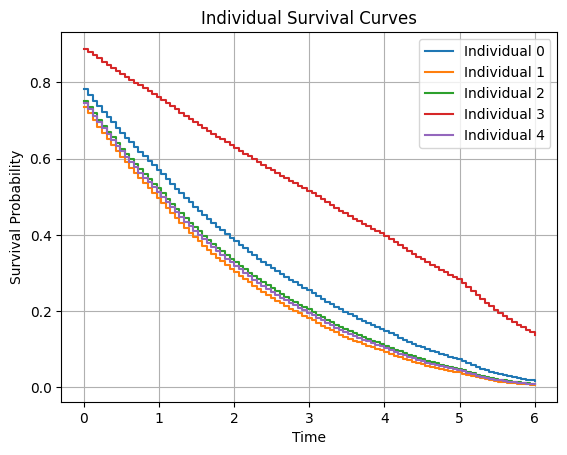

CPU times: total: 484 ms
Wall time: 1.62 s


In [70]:
%%time
from lifelines import CoxPHFitter
from lifelines.utils import median_survival_times
from lifelines.utils import concordance_index

# Train the Cox Proportional Hazards model with L2 regularization
coxph = CoxPHFitter(penalizer=0.01)
coxph.fit(train1_data_new, duration_col='Survival months', event_col='Vital status')

# Define a function to calculate the mean survival time from the survival function
#def mean_survival_time(survival_function):
    #return np.trapz(survival_function.values, survival_function.index)

# Predict the mean survival time for each individual in the test set
#predicted_means = test_data_survival_curves.apply(mean_survival_time, axis=0)
predicted_means  = coxph.predict_expectation(test1_data_new.drop(['Vital status', 'Survival months'], axis=1))

# Convert the predictions to a DataFrame for further processing
predicted_means = pd.DataFrame(predicted_means, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results = pd.concat([test1_data_new.reset_index(drop=True), predicted_means.reset_index(drop=True)], axis=1)
print(results[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']] )

# Calculate RMSE for Mean Predictions
mse_mean = mean_squared_error(results['Survival months'], results['Predicted Survival Time (Mean)'])
rmse_mean = np.sqrt(mse_mean)
print("Root Mean Squared Error (RMSE) with Mean Prediction:", rmse_mean)

# Calculate RRMSE
mean_observed = np.mean(results['Survival months'])
rrmse_mean = rmse_mean / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results['Survival months'], results['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Calculate C-index
c_index = coxph.score(test1_data_new, scoring_method="concordance_index")
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Estimate the survival function for each individual in the test set
test_data_survival_curves = coxph.predict_survival_function(test1_data_new, times=np.linspace(0, max(y1_surv_train), 100))

# Visualize the survival curves
for i in range(min(5, len(test_data_survival_curves.columns))):  # Plot survival curves for the first 5 individuals
    plt.step(test_data_survival_curves.index, test_data_survival_curves.iloc[:, i], where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves')
plt.legend()
plt.grid(True)
plt.show()

##### 7-24 months

      Survival months  Vital status  Predicted Survival Time (Mean)
0                  14             1                        7.333381
1                  10             0                        9.732660
2                   8             1                        7.293492
3                   9             1                        7.209785
4                  22             1                        7.665336
...               ...           ...                             ...
2608                7             1                        6.036784
2609               22             1                        6.080070
2610               10             1                        5.904918
2611               13             1                        6.218450
2612               13             1                        7.040474

[2613 rows x 3 columns]
Root Mean Squared Error (RMSE) with Mean Prediction: 8.559031218612928
Root Relative Mean Squared Error (RRMSE) with Mean Prediction: 0.6205018609504087
Mean A

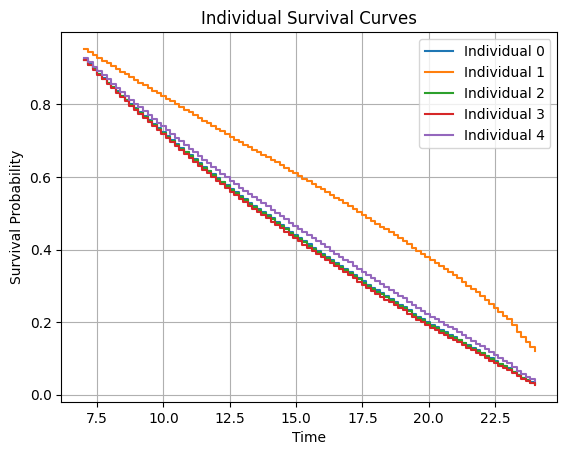

CPU times: total: 93.8 ms
Wall time: 666 ms


In [71]:
%%time
from lifelines import CoxPHFitter
from lifelines.utils import median_survival_times
from lifelines.utils import concordance_index

# Train the Cox Proportional Hazards model with L2 regularization
coxph = CoxPHFitter(penalizer=0.01)
coxph.fit(train2_data_new, duration_col='Survival months', event_col='Vital status')

# Define a function to calculate the mean survival time from the survival function
#def mean_survival_time(survival_function):
    #return np.trapz(survival_function.values, survival_function.index)

# Predict the mean survival time for each individual in the test set
#predicted_means = test_data_survival_curves.apply(mean_survival_time, axis=0)
predicted_means  = coxph.predict_expectation(test2_data_new.drop(['Vital status', 'Survival months'], axis=1))

# Convert the predictions to a DataFrame for further processing
predicted_means = pd.DataFrame(predicted_means, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results = pd.concat([test2_data_new.reset_index(drop=True), predicted_means.reset_index(drop=True)], axis=1)
print(results[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']] )

# Calculate RMSE for Mean Predictions
mse_mean = mean_squared_error(results['Survival months'], results['Predicted Survival Time (Mean)'])
rmse_mean = np.sqrt(mse_mean)
print("Root Mean Squared Error (RMSE) with Mean Prediction:", rmse_mean)

# Calculate RRMSE
mean_observed = np.mean(results['Survival months'])
rrmse_mean = rmse_mean / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results['Survival months'], results['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Calculate C-index
c_index = coxph.score(test2_data_new, scoring_method="concordance_index")
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Estimate the survival function for each individual in the test set
test_data_survival_curves = coxph.predict_survival_function(test2_data_new, times=np.linspace(7, max(y2_surv_train), 100))

# Visualize the survival curves
for i in range(min(5, len(test_data_survival_curves.columns))):  # Plot survival curves for the first 5 individuals
    plt.step(test_data_survival_curves.index, test_data_survival_curves.iloc[:, i], where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves')
plt.legend()
plt.grid(True)
plt.show()

##### >24 months

      Survival months  Vital status  Predicted Survival Time (Mean)
0                  39             0                       19.684165
1                  34             1                       20.292881
2                  47             0                       19.844499
3                  43             0                       20.265378
4                  39             0                       17.269461
...               ...           ...                             ...
4264               47             0                       19.806033
4265               31             1                       15.346164
4266               36             0                       17.559609
4267               30             1                       15.577304
4268               40             0                       19.941645

[4269 rows x 3 columns]
Root Mean Squared Error (RMSE) with Mean Prediction: 21.553867533158243
Root Relative Mean Squared Error (RRMSE) with Mean Prediction: 0.5513386611563987
Mean 

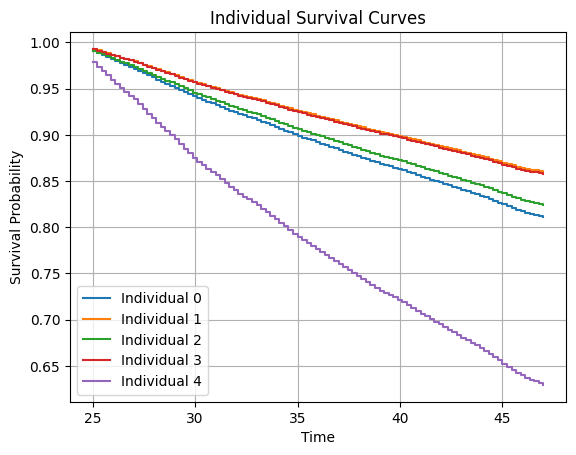

CPU times: total: 125 ms
Wall time: 649 ms


In [72]:
%%time
from lifelines import CoxPHFitter
from lifelines.utils import median_survival_times
from lifelines.utils import concordance_index

# Train the Cox Proportional Hazards model with L2 regularization
coxph = CoxPHFitter(penalizer=0.01)
coxph.fit(train3_data_new, duration_col='Survival months', event_col='Vital status')

# Define a function to calculate the mean survival time from the survival function
#def mean_survival_time(survival_function):
    #return np.trapz(survival_function.values, survival_function.index)

# Predict the mean survival time for each individual in the test set
#predicted_means = test_data_survival_curves.apply(mean_survival_time, axis=0)
predicted_means  = coxph.predict_expectation(test3_data_new.drop(['Vital status', 'Survival months'], axis=1))

# Convert the predictions to a DataFrame for further processing
predicted_means = pd.DataFrame(predicted_means, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results = pd.concat([test3_data_new.reset_index(drop=True), predicted_means.reset_index(drop=True)], axis=1)
print(results[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']] )

# Calculate RMSE for Mean Predictions
mse_mean = mean_squared_error(results['Survival months'], results['Predicted Survival Time (Mean)'])
rmse_mean = np.sqrt(mse_mean)
print("Root Mean Squared Error (RMSE) with Mean Prediction:", rmse_mean)

# Calculate RRMSE
mean_observed = np.mean(results['Survival months'])
rrmse_mean = rmse_mean / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results['Survival months'], results['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Calculate C-index
c_index = coxph.score(test3_data_new, scoring_method="concordance_index")
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Estimate the survival function for each individual in the test set
test_data_survival_curves = coxph.predict_survival_function(test3_data_new, times=np.linspace(25, max(y3_surv_train), 100))

# Visualize the survival curves
for i in range(min(5, len(test_data_survival_curves.columns))):  # Plot survival curves for the first 5 individuals
    plt.step(test_data_survival_curves.index, test_data_survival_curves.iloc[:, i], where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves')
plt.legend()
plt.grid(True)
plt.show()

### 2. Random Survival Forest

#### Mean

##### ≤6 months

      Survival months  Vital status  Predicted Survival Time (Mean)
0                   2             1                        1.047518
1                   2             1                        1.318903
2                   1             1                        1.306442
3                   1             1                        3.163385
4                   0             1                        0.751531
...               ...           ...                             ...
3553                3             1                        2.339863
3554                0             1                        0.750976
3555                0             1                        0.748175
3556                0             1                        0.687393
3557                1             1                        1.457646

[3558 rows x 3 columns]
Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction: 1.7102926226089303
Root Relative Mean Squared Error (RRMSE) with Mean Prediction: 0

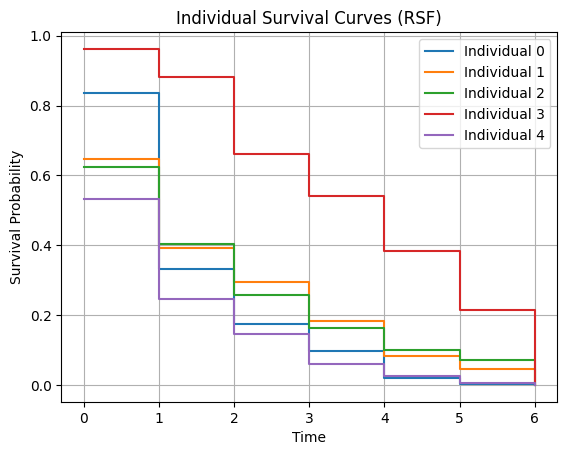

CPU times: total: 18.8 s
Wall time: 39.9 s


In [73]:
%%time

# Initialize and train the Random Survival Forest model
rsf = RandomSurvivalForest(n_jobs=-1, random_state=42)
rsf.fit(x1_train_df, y1_train_structured)

# Predict survival functions for the test set
test_surv_curves = rsf.predict_survival_function(x1_test_df, return_array=False)

# Calculate mean survival time for each individual
def mean_survival_time_rsfs(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_rsf = mean_survival_time_rsfs(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df = pd.DataFrame(predicted_means_rsf, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_rsf = pd.concat([test1_data_new.reset_index(drop=True), predicted_means_df.reset_index(drop=True)], axis=1)
print(results_rsf[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_rsf = mean_squared_error(results_rsf['Survival months'], results_rsf['Predicted Survival Time (Mean)'])
rmse_mean_rsf = np.sqrt(mse_mean_rsf)
print("Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction:", rmse_mean_rsf)

# Calculate RRMSE
mean_observed = np.mean(results_rsf['Survival months'])
rrmse_mean = rmse_mean_rsf / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate C-index
c_index = rsf.score(test1_data_new.drop(['Vital status', 'Survival months'], axis=1), y1_test_structured)
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_rsf['Survival months'], results_rsf['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (RSF)')
plt.legend()
plt.grid(True)
plt.show()

##### 7-24 months

      Survival months  Vital status  Predicted Survival Time (Mean)
0                  14             1                        7.076646
1                  10             0                       10.916142
2                   8             1                        7.079048
3                   9             1                        6.552639
4                  22             1                        7.356456
...               ...           ...                             ...
2608                7             1                        5.724360
2609               22             1                        6.274201
2610               10             1                        6.386454
2611               13             1                        5.371240
2612               13             1                        6.923354

[2613 rows x 3 columns]
Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction: 8.8140696334394
Root Relative Mean Squared Error (RRMSE) with Mean Prediction: 0.63

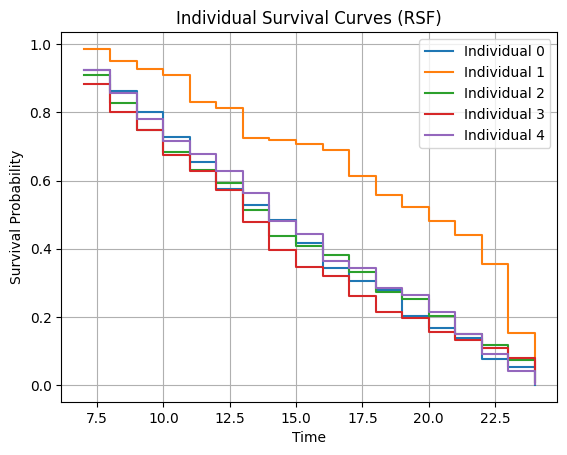

CPU times: total: 30.9 s
Wall time: 1min 3s


In [74]:
%%time

# Initialize and train the Random Survival Forest model
rsf = RandomSurvivalForest(n_jobs=-1, random_state=42)
rsf.fit(x2_train_df, y2_train_structured)

# Predict survival functions for the test set
test_surv_curves = rsf.predict_survival_function(x2_test_df, return_array=False)

# Calculate mean survival time for each individual
def mean_survival_time_rsfs(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_rsf = mean_survival_time_rsfs(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df = pd.DataFrame(predicted_means_rsf, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_rsf = pd.concat([test2_data_new.reset_index(drop=True), predicted_means_df.reset_index(drop=True)], axis=1)
print(results_rsf[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_rsf = mean_squared_error(results_rsf['Survival months'], results_rsf['Predicted Survival Time (Mean)'])
rmse_mean_rsf = np.sqrt(mse_mean_rsf)
print("Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction:", rmse_mean_rsf)

# Calculate RRMSE
mean_observed = np.mean(results_rsf['Survival months'])
rrmse_mean = rmse_mean_rsf / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate C-index
c_index = rsf.score(test2_data_new.drop(['Vital status', 'Survival months'], axis=1), y2_test_structured)
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_rsf['Survival months'], results_rsf['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (RSF)')
plt.legend()
plt.grid(True)
plt.show()

##### ＞24 months

      Survival months  Vital status  Predicted Survival Time (Mean)
0                  39             0                       18.812768
1                  34             1                       18.094062
2                  47             0                       19.444122
3                  43             0                       19.951327
4                  39             0                       16.585896
...               ...           ...                             ...
4264               47             0                       20.373076
4265               31             1                       14.706678
4266               36             0                       18.385639
4267               30             1                       15.657748
4268               40             0                       19.406577

[4269 rows x 3 columns]
Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction: 21.54656531932966
Root Relative Mean Squared Error (RRMSE) with Mean Prediction: 0.

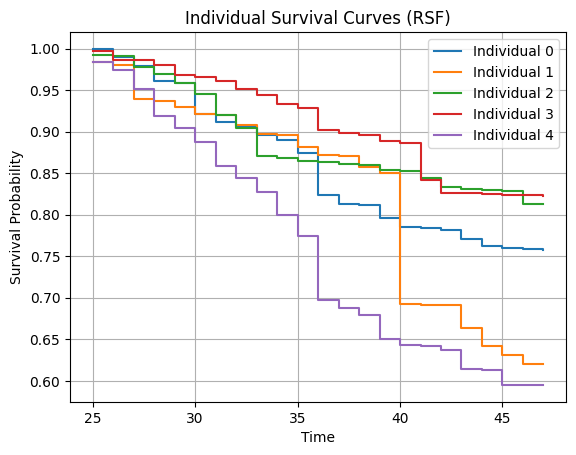

CPU times: total: 46.2 s
Wall time: 1min 38s


In [75]:
%%time

# Initialize and train the Random Survival Forest model
rsf = RandomSurvivalForest(n_jobs=-1, random_state=42)
rsf.fit(x3_train_df, y3_train_structured)

# Predict survival functions for the test set
test_surv_curves = rsf.predict_survival_function(x3_test_df, return_array=False)

# Calculate mean survival time for each individual
def mean_survival_time_rsfs(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_rsf = mean_survival_time_rsfs(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df = pd.DataFrame(predicted_means_rsf, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_rsf = pd.concat([test3_data_new.reset_index(drop=True), predicted_means_df.reset_index(drop=True)], axis=1)
print(results_rsf[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_rsf = mean_squared_error(results_rsf['Survival months'], results_rsf['Predicted Survival Time (Mean)'])
rmse_mean_rsf = np.sqrt(mse_mean_rsf)
print("Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction:", rmse_mean_rsf)

# Calculate RRMSE
mean_observed = np.mean(results_rsf['Survival months'])
rrmse_mean = rmse_mean_rsf / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate C-index
c_index = rsf.score(test3_data_new.drop(['Vital status', 'Survival months'], axis=1), y3_test_structured)
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_rsf['Survival months'], results_rsf['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (RSF)')
plt.legend()
plt.grid(True)
plt.show()

### 3. GradientBoostingSurvivalAnalysis

##### ≤6 months

In [76]:
%%time
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
# Initialize and train the Gradient Boosting Survival Analysis model
gbm = GradientBoostingSurvivalAnalysis(random_state=42)
gbm.fit(x1_train_df, y1_train_structured)


CPU times: total: 1min 9s
Wall time: 1min 48s


GradientBoostingSurvivalAnalysis(random_state=42)

      Survival months  Vital status  Predicted Survival Time (Mean)
0                   2             1                        1.623041
1                   2             1                        1.570904
2                   1             1                        1.476593
3                   1             1                        2.906808
4                   0             1                        1.427760
...               ...           ...                             ...
3553                3             1                        2.779650
3554                0             1                        1.268927
3555                0             1                        1.163198
3556                0             1                        1.175215
3557                1             1                        1.173187

[3558 rows x 3 columns]
Root Mean Squared Error (RMSE) with GBM Mean Prediction: 1.6772586913183725
Root Relative Mean Squared Error (RRMSE) with Mean Prediction: 0.7657752372270973
M

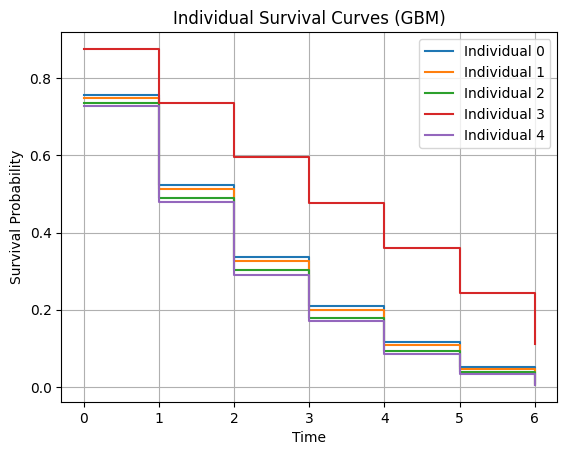

In [77]:
# Predict survival functions for the test set
test_surv_curves = gbm.predict_survival_function(x1_test_df)

# Calculate mean survival time for each individual
def mean_survival_time_gbm(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_gbm = mean_survival_time_gbm(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df = pd.DataFrame(predicted_means_gbm, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_gbm = pd.concat([test1_data_new.reset_index(drop=True), predicted_means_df.reset_index(drop=True)], axis=1)
print(results_gbm[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_gbm = mean_squared_error(results_gbm['Survival months'], results_gbm['Predicted Survival Time (Mean)'])
rmse_mean_gbm = np.sqrt(mse_mean_gbm)
print("Root Mean Squared Error (RMSE) with GBM Mean Prediction:", rmse_mean_gbm)

# Calculate RRMSE
mean_observed = np.mean(results_gbm['Survival months'])
rrmse_mean = rmse_mean_gbm / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_gbm['Survival months'], results_gbm['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Calculate C-index
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
c_index = gbm.score(test1_data_new.drop(['Vital status', 'Survival months'], axis=1), y1_test_structured)
print("Concordance Index (C-index) of testing set:", c_index)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (GBM)')
plt.legend()
plt.grid(True)
plt.show()

##### 7-24 months

In [78]:
%%time
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
# Initialize and train the Gradient Boosting Survival Analysis model
gbm = GradientBoostingSurvivalAnalysis(random_state=42)
gbm.fit(x2_train_df, y2_train_structured)

CPU times: total: 34.7 s
Wall time: 58.6 s


GradientBoostingSurvivalAnalysis(random_state=42)

      Survival months  Vital status  Predicted Survival Time (Mean)
0                  14             1                        7.364051
1                  10             0                        9.617202
2                   8             1                        6.700268
3                   9             1                        6.971914
4                  22             1                        7.982569
...               ...           ...                             ...
2608                7             1                        5.499631
2609               22             1                        5.970200
2610               10             1                        6.611740
2611               13             1                        6.625175
2612               13             1                        7.797201

[2613 rows x 3 columns]
Root Mean Squared Error (RMSE) with GBM Mean Prediction: 8.596430933518974
Root Relative Mean Squared Error (RRMSE) with Mean Prediction: 0.6232132183582132
Me

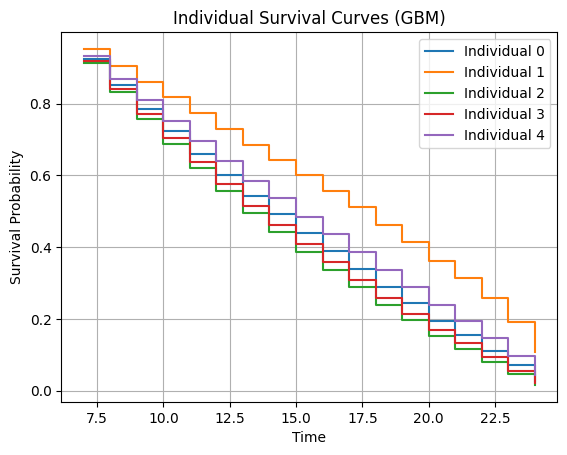

In [79]:
# Predict survival functions for the test set
test_surv_curves = gbm.predict_survival_function(x2_test_df)

# Calculate mean survival time for each individual
def mean_survival_time_gbm(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_gbm = mean_survival_time_gbm(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df = pd.DataFrame(predicted_means_gbm, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_gbm = pd.concat([test2_data_new.reset_index(drop=True), predicted_means_df.reset_index(drop=True)], axis=1)
print(results_gbm[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_gbm = mean_squared_error(results_gbm['Survival months'], results_gbm['Predicted Survival Time (Mean)'])
rmse_mean_gbm = np.sqrt(mse_mean_gbm)
print("Root Mean Squared Error (RMSE) with GBM Mean Prediction:", rmse_mean_gbm)

# Calculate RRMSE
mean_observed = np.mean(results_gbm['Survival months'])
rrmse_mean = rmse_mean_gbm / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_gbm['Survival months'], results_gbm['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Calculate C-index
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
c_index = gbm.score(test2_data_new.drop(['Vital status', 'Survival months'], axis=1), y2_test_structured)
print("Concordance Index (C-index) of testing set:", c_index)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (GBM)')
plt.legend()
plt.grid(True)
plt.show()

##### ＞24 months

In [80]:
%%time
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
# Initialize and train the Gradient Boosting Survival Analysis model
gbm = GradientBoostingSurvivalAnalysis(random_state=42)
gbm.fit(x3_train_df, y3_train_structured)

CPU times: total: 1min 22s
Wall time: 2min 26s


GradientBoostingSurvivalAnalysis(random_state=42)

      Survival months  Vital status  Predicted Survival Time (Mean)
0                  39             0                       19.830918
1                  34             1                       19.512861
2                  47             0                       19.988452
3                  43             0                       19.748454
4                  39             0                       16.586127
...               ...           ...                             ...
4264               47             0                       19.663998
4265               31             1                       15.560211
4266               36             0                       17.413900
4267               30             1                       16.553681
4268               40             0                       19.676033

[4269 rows x 3 columns]
Root Mean Squared Error (RMSE) with GBM Mean Prediction: 21.55960544551196
Root Relative Mean Squared Error (RRMSE) with Mean Prediction: 0.5514854344865244
Me

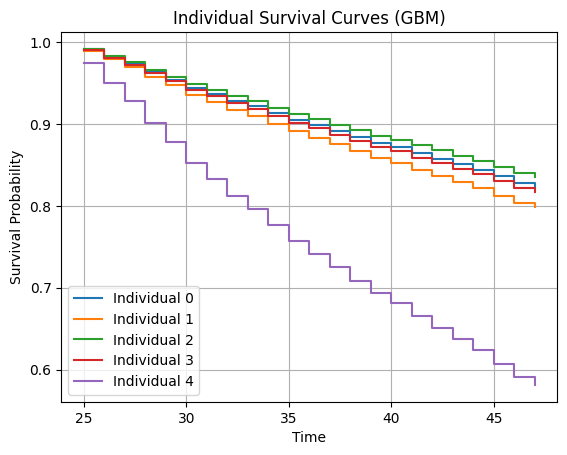

In [81]:
# Predict survival functions for the test set
test_surv_curves = gbm.predict_survival_function(x3_test_df)

# Calculate mean survival time for each individual
def mean_survival_time_gbm(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_gbm = mean_survival_time_gbm(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df = pd.DataFrame(predicted_means_gbm, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_gbm = pd.concat([test3_data_new.reset_index(drop=True), predicted_means_df.reset_index(drop=True)], axis=1)
print(results_gbm[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_gbm = mean_squared_error(results_gbm['Survival months'], results_gbm['Predicted Survival Time (Mean)'])
rmse_mean_gbm = np.sqrt(mse_mean_gbm)
print("Root Mean Squared Error (RMSE) with GBM Mean Prediction:", rmse_mean_gbm)

# Calculate RRMSE
mean_observed = np.mean(results_gbm['Survival months'])
rrmse_mean = rmse_mean_gbm / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_gbm['Survival months'], results_gbm['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Calculate C-index
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
c_index = gbm.score(test3_data_new.drop(['Vital status', 'Survival months'], axis=1), y3_test_structured)
print("Concordance Index (C-index) of testing set:", c_index)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (GBM)')
plt.legend()
plt.grid(True)
plt.show()

### 4. SurvivalTree

##### ＜6 months

In [82]:
%%time
from sksurv.tree import SurvivalTree

# Prepare feature matrices
X_train = train1_data_new.drop(['Vital status', 'Survival months'], axis=1)
X_test = test1_data_new.drop(['Vital status', 'Survival months'], axis=1)

# Initialize and train the SurvivalTree model
tree = SurvivalTree(random_state=42)
tree.fit(X_train, y1_train_structured)


CPU times: total: 188 ms
Wall time: 447 ms


SurvivalTree(random_state=42)

SurvivalTree Results:
       Survival months  Vital status  Predicted Survival Time (Mean)
0                   2             1                        2.300000
1                   2             1                        0.625000
2                   1             1                        0.000000
3                   1             1                        1.166667
4                   0             1                        0.000000
...               ...           ...                             ...
3553                3             1                        1.625000
3554                0             1                        1.375000
3555                0             1                        0.500000
3556                0             1                        0.375000
3557                1             1                        2.333333

[3558 rows x 3 columns]
Root Mean Squared Error (RMSE) with SurvivalTree Mean Prediction: 2.086552582695958
Root Relative Mean Squared Error (RRMSE) with Mean P

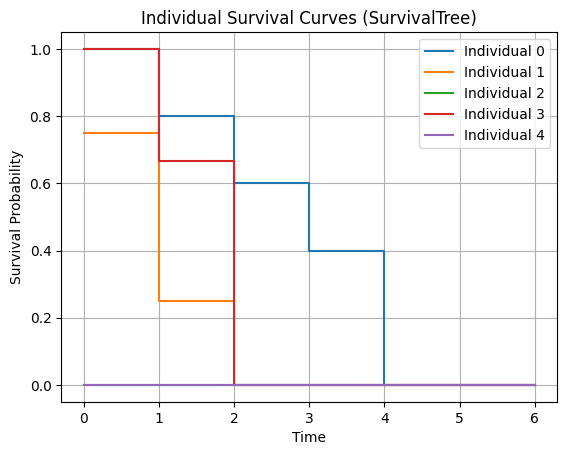

In [83]:
# Predict survival functions for the test set
test_surv_curves = tree.predict_survival_function(X_test)

# Function to calculate mean survival time
def mean_survival_time(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

# Calculate mean survival time for SurvivalTree
predicted_means_tree = mean_survival_time(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df_tree = pd.DataFrame(predicted_means_tree, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_tree = pd.concat([test1_data_new.reset_index(drop=True), predicted_means_df_tree.reset_index(drop=True)], axis=1)

# Print results
print("SurvivalTree Results:\n", results_tree[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_tree = mean_squared_error(results_tree['Survival months'], results_tree['Predicted Survival Time (Mean)'])
rmse_mean_tree = np.sqrt(mse_mean_tree)
print("Root Mean Squared Error (RMSE) with SurvivalTree Mean Prediction:", rmse_mean_tree)

# Calculate RRMSE
mean_observed = np.mean(results_tree['Survival months'])
rrmse_mean = rmse_mean_tree / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_tree['Survival months'], results_tree['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Calculate C-index
c_index = tree.score(test1_data_new.drop(['Vital status', 'Survival months'], axis=1), y1_test_structured)
print("Concordance Index (C-index) of testing set:", c_index)


# Visualize the survival curves for the first 5 individuals
for i in range(min(5, len(test_surv_curves))):
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (SurvivalTree)')
plt.legend()
plt.grid(True)
plt.show()

##### 7-24 months

In [84]:
%%time
from sksurv.tree import SurvivalTree

# Prepare feature matrices
X_train = train2_data_new.drop(['Vital status', 'Survival months'], axis=1)
X_test = test2_data_new.drop(['Vital status', 'Survival months'], axis=1)

# Initialize and train the SurvivalTree model
tree = SurvivalTree(random_state=42)
tree.fit(X_train, y2_train_structured)

CPU times: total: 188 ms
Wall time: 477 ms


SurvivalTree(random_state=42)

SurvivalTree Results:
       Survival months  Vital status  Predicted Survival Time (Mean)
0                  14             1                        5.166667
1                  10             0                       16.000000
2                   8             1                       13.500000
3                   9             1                        3.700000
4                  22             1                        9.500000
...               ...           ...                             ...
2608                7             1                        2.500000
2609               22             1                        3.750000
2610               10             1                       11.166667
2611               13             1                        2.300000
2612               13             1                        7.750000

[2613 rows x 3 columns]
Root Mean Squared Error (RMSE) with SurvivalTree Mean Prediction: 9.571465841686999
Root Relative Mean Squared Error (RRMSE) with Mean P

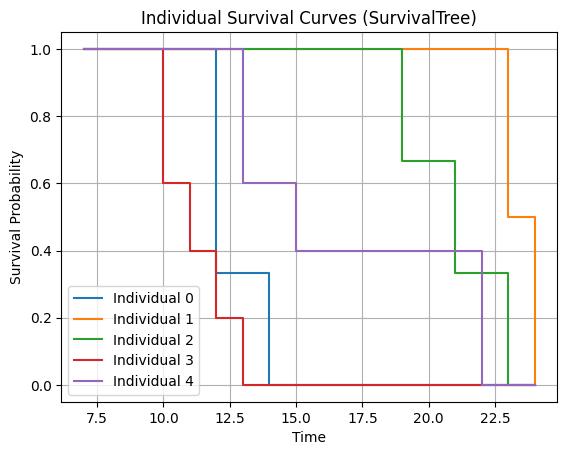

In [85]:
# Predict survival functions for the test set
test_surv_curves = tree.predict_survival_function(X_test)

# Function to calculate mean survival time
def mean_survival_time(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

# Calculate mean survival time for SurvivalTree
predicted_means_tree = mean_survival_time(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df_tree = pd.DataFrame(predicted_means_tree, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_tree = pd.concat([test2_data_new.reset_index(drop=True), predicted_means_df_tree.reset_index(drop=True)], axis=1)

# Print results
print("SurvivalTree Results:\n", results_tree[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_tree = mean_squared_error(results_tree['Survival months'], results_tree['Predicted Survival Time (Mean)'])
rmse_mean_tree = np.sqrt(mse_mean_tree)
print("Root Mean Squared Error (RMSE) with SurvivalTree Mean Prediction:", rmse_mean_tree)

# Calculate RRMSE
mean_observed = np.mean(results_tree['Survival months'])
rrmse_mean = rmse_mean_tree / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_tree['Survival months'], results_tree['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Calculate C-index
c_index = tree.score(test2_data_new.drop(['Vital status', 'Survival months'], axis=1), y2_test_structured)
print("Concordance Index (C-index) of testing set:", c_index)


# Visualize the survival curves for the first 5 individuals
for i in range(min(5, len(test_surv_curves))):
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (SurvivalTree)')
plt.legend()
plt.grid(True)
plt.show()

##### ＞24 months

In [86]:
%%time
from sksurv.tree import SurvivalTree

# Prepare feature matrices
X_train = train3_data_new.drop(['Vital status', 'Survival months'], axis=1)
X_test = test3_data_new.drop(['Vital status', 'Survival months'], axis=1)

# Initialize and train the SurvivalTree model
tree = SurvivalTree(random_state=42)
tree.fit(X_train, y3_train_structured)

CPU times: total: 312 ms
Wall time: 599 ms


SurvivalTree(random_state=42)

SurvivalTree Results:
       Survival months  Vital status  Predicted Survival Time (Mean)
0                  39             0                       22.000000
1                  34             1                       18.100000
2                  47             0                       22.000000
3                  43             0                       22.000000
4                  39             0                       12.700000
...               ...           ...                             ...
4264               47             0                       22.000000
4265               31             1                       22.000000
4266               36             0                       17.166667
4267               30             1                        7.750000
4268               40             0                       22.000000

[4269 rows x 3 columns]
Root Mean Squared Error (RMSE) with SurvivalTree Mean Prediction: 22.120145549534044
Root Relative Mean Squared Error (RRMSE) with Mean 

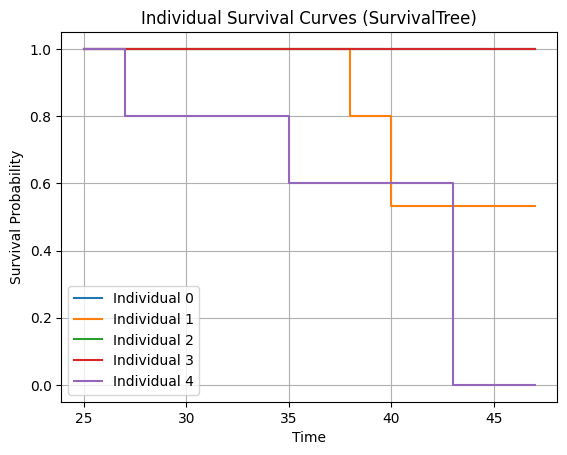

In [87]:
# Predict survival functions for the test set
test_surv_curves = tree.predict_survival_function(X_test)

# Function to calculate mean survival time
def mean_survival_time(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

# Calculate mean survival time for SurvivalTree
predicted_means_tree = mean_survival_time(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df_tree = pd.DataFrame(predicted_means_tree, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_tree = pd.concat([test3_data_new.reset_index(drop=True), predicted_means_df_tree.reset_index(drop=True)], axis=1)

# Print results
print("SurvivalTree Results:\n", results_tree[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_tree = mean_squared_error(results_tree['Survival months'], results_tree['Predicted Survival Time (Mean)'])
rmse_mean_tree = np.sqrt(mse_mean_tree)
print("Root Mean Squared Error (RMSE) with SurvivalTree Mean Prediction:", rmse_mean_tree)

# Calculate RRMSE
mean_observed = np.mean(results_tree['Survival months'])
rrmse_mean = rmse_mean_tree / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_tree['Survival months'], results_tree['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Calculate C-index
c_index = tree.score(test3_data_new.drop(['Vital status', 'Survival months'], axis=1), y3_test_structured)
print("Concordance Index (C-index) of testing set:", c_index)


# Visualize the survival curves for the first 5 individuals
for i in range(min(5, len(test_surv_curves))):
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (SurvivalTree)')
plt.legend()
plt.grid(True)
plt.show()

### 5. Stacking

##### ≤6 months

In [88]:
%%time
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.tree import SurvivalTree
from sksurv.meta import Stacking

# Initialize base models
rsf = RandomSurvivalForest(random_state=42)
gbsa = GradientBoostingSurvivalAnalysis(random_state=42)
st = SurvivalTree(random_state=42)

# Initialize meta-model (Cox Proportional Hazards model)
meta_model = CoxPHSurvivalAnalysis()

# Initialize Stacking model
stacking_model = Stacking(
    meta_estimator=meta_model,
    base_estimators=[
        ("rsf", rsf),
        ("gbsa", gbsa),
        ("st", st)
    ],
    probabilities=False  # Set to False if base models do not support predict_proba
)

# Train the stacking model
stacking_model.fit(x1_train_df, y1_train_structured)

CPU times: total: 59.8 s
Wall time: 1min 59s


Stacking(base_estimators=[('rsf', RandomSurvivalForest(random_state=42)),
                          ('gbsa',
                           GradientBoostingSurvivalAnalysis(random_state=42)),
                          ('st', SurvivalTree(random_state=42))],
         meta_estimator=CoxPHSurvivalAnalysis(), probabilities=False)

      Survival months  Vital status  Predicted Survival Time (Mean)
0                   2             1                        1.752817
1                   2             1                        0.739772
2                   1             1                        2.072207
3                   1             1                        2.952037
4                   0             1                        0.757743
...               ...           ...                             ...
3553                3             1                        1.742609
3554                0             1                        1.115804
3555                0             1                        2.029154
3556                0             1                        1.612242
3557                1             1                        2.906319

[3558 rows x 3 columns]
Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction: 1.7943180440773137
Root Relative Mean Squared Error (RRMSE) with Mean Prediction: 0

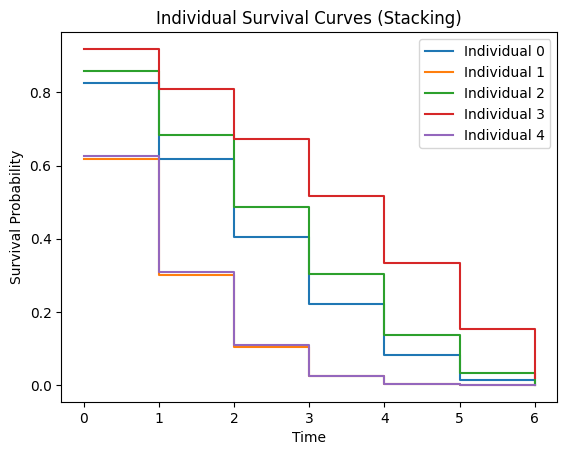

In [89]:
# Predict survival functions for the test set
test_surv_curves = stacking_model.predict_survival_function(x1_test_df, return_array=False)

# Calculate mean survival time for each individual
def mean_survival_time_sta(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_sta = mean_survival_time_sta(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df = pd.DataFrame(predicted_means_sta, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_sta = pd.concat([test1_data_new.reset_index(drop=True), predicted_means_df.reset_index(drop=True)], axis=1)
print(results_sta[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_sta = mean_squared_error(results_sta['Survival months'], results_sta['Predicted Survival Time (Mean)'])
rmse_mean_sta = np.sqrt(mse_mean_sta)
print("Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction:", rmse_mean_sta)

# Calculate RRMSE
mean_observed = np.mean(results_sta['Survival months'])
rrmse_mean = rmse_mean_sta / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate C-index
c_index = stacking_model.score(test1_data_new.drop(['Vital status', 'Survival months'], axis=1), y1_test_structured)
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_sta['Survival months'], results_sta['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (Stacking)')
plt.legend()
plt.show()

##### 7-24 months

In [90]:
# Initialize base models
rsf = RandomSurvivalForest(random_state=42)
gbsa = GradientBoostingSurvivalAnalysis(random_state=42)
st = SurvivalTree(random_state=42)

# Initialize meta-model (Cox Proportional Hazards model)
meta_model = CoxPHSurvivalAnalysis()

# Initialize Stacking model
stacking_model = Stacking(
    meta_estimator=meta_model,
    base_estimators=[
        ("rsf", rsf),
        ("gbsa", gbsa),
        ("st", st)
    ],
    probabilities=False  # Set to False if base models do not support predict_proba
)

# Train the stacking model
stacking_model.fit(x2_train_df, y2_train_structured)

Stacking(base_estimators=[('rsf', RandomSurvivalForest(random_state=42)),
                          ('gbsa',
                           GradientBoostingSurvivalAnalysis(random_state=42)),
                          ('st', SurvivalTree(random_state=42))],
         meta_estimator=CoxPHSurvivalAnalysis(), probabilities=False)

      Survival months  Vital status  Predicted Survival Time (Mean)
0                  14             1                        5.558932
1                  10             0                       15.112543
2                   8             1                       11.914241
3                   9             1                        3.341295
4                  22             1                        9.149653
...               ...           ...                             ...
2608                7             1                        4.365223
2609               22             1                        5.992234
2610               10             1                        9.680431
2611               13             1                        1.954811
2612               13             1                        6.959047

[2613 rows x 3 columns]
Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction: 9.1324732328126
Root Relative Mean Squared Error (RRMSE) with Mean Prediction: 0.66

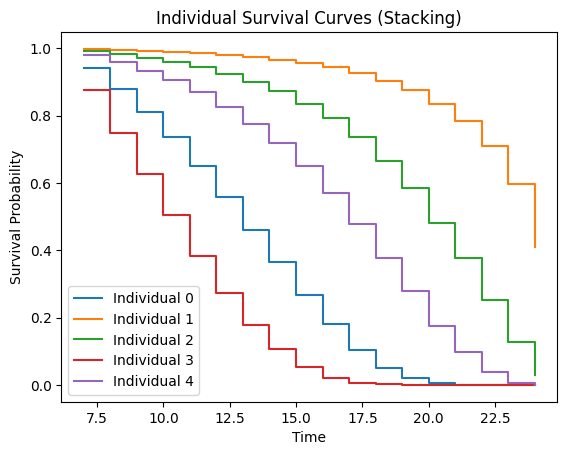

In [91]:
# Predict survival functions for the test set
test_surv_curves = stacking_model.predict_survival_function(x2_test_df, return_array=False)

# Calculate mean survival time for each individual
def mean_survival_time_sta(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_sta = mean_survival_time_sta(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df = pd.DataFrame(predicted_means_sta, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_sta = pd.concat([test2_data_new.reset_index(drop=True), predicted_means_df.reset_index(drop=True)], axis=1)
print(results_sta[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_sta = mean_squared_error(results_sta['Survival months'], results_sta['Predicted Survival Time (Mean)'])
rmse_mean_sta = np.sqrt(mse_mean_sta)
print("Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction:", rmse_mean_sta)

# Calculate RRMSE
mean_observed = np.mean(results_sta['Survival months'])
rrmse_mean = rmse_mean_sta / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate C-index
c_index = stacking_model.score(test2_data_new.drop(['Vital status', 'Survival months'], axis=1), y2_test_structured)
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_sta['Survival months'], results_sta['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (Stacking)')
plt.legend()
plt.show()

##### ＞24 months

In [92]:
# Initialize base models
rsf = RandomSurvivalForest(random_state=42)
gbsa = GradientBoostingSurvivalAnalysis(random_state=42)
st = SurvivalTree(random_state=42)

# Initialize meta-model (Cox Proportional Hazards model)
meta_model = CoxPHSurvivalAnalysis()

# Initialize Stacking model
stacking_model = Stacking(
    meta_estimator=meta_model,
    base_estimators=[
        ("rsf", rsf),
        ("gbsa", gbsa),
        ("st", st)
    ],
    probabilities=False  # Set to False if base models do not support predict_proba
)

# Train the stacking model
stacking_model.fit(x3_train_df, y3_train_structured)

Stacking(base_estimators=[('rsf', RandomSurvivalForest(random_state=42)),
                          ('gbsa',
                           GradientBoostingSurvivalAnalysis(random_state=42)),
                          ('st', SurvivalTree(random_state=42))],
         meta_estimator=CoxPHSurvivalAnalysis(), probabilities=False)

      Survival months  Vital status  Predicted Survival Time (Mean)
0                  39             0                       19.693227
1                  34             1                       18.690174
2                  47             0                       20.156767
3                  43             0                       20.646546
4                  39             0                       17.797396
...               ...           ...                             ...
4264               47             0                       20.894618
4265               31             1                       18.810107
4266               36             0                       20.561084
4267               30             1                        9.163140
4268               40             0                       20.363186

[4269 rows x 3 columns]
Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction: 21.27777695352592
Root Relative Mean Squared Error (RRMSE) with Mean Prediction: 0.

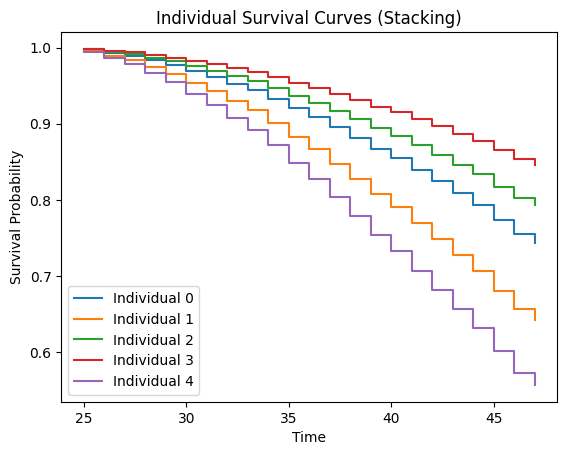

In [93]:
# Predict survival functions for the test set
test_surv_curves = stacking_model.predict_survival_function(x3_test_df, return_array=False)

# Calculate mean survival time for each individual
def mean_survival_time_sta(surv_funcs):
    mean_times = []
    for surv_func in surv_funcs:
        times = surv_func.x
        survival_probs = surv_func.y
        mean_time = np.trapz(survival_probs, times)
        mean_times.append(mean_time)
    return np.array(mean_times)

predicted_means_sta = mean_survival_time_sta(test_surv_curves)

# Convert the predictions to a DataFrame for further processing
predicted_means_df = pd.DataFrame(predicted_means_sta, columns=['Predicted Survival Time (Mean)'])

# Merge the prediction results with the actual test data
results_sta = pd.concat([test3_data_new.reset_index(drop=True), predicted_means_df.reset_index(drop=True)], axis=1)
print(results_sta[['Survival months', 'Vital status', 'Predicted Survival Time (Mean)']])

# Calculate RMSE for Mean Predictions
mse_mean_sta = mean_squared_error(results_sta['Survival months'], results_sta['Predicted Survival Time (Mean)'])
rmse_mean_sta = np.sqrt(mse_mean_sta)
print("Root Mean Squared Error (RMSE) with Random Survival Forest Mean Prediction:", rmse_mean_sta)

# Calculate RRMSE
mean_observed = np.mean(results_sta['Survival months'])
rrmse_mean = rmse_mean_sta / mean_observed
print("Root Relative Mean Squared Error (RRMSE) with Mean Prediction:", rrmse_mean)

# Calculate C-index
c_index = stacking_model.score(test3_data_new.drop(['Vital status', 'Survival months'], axis=1), y3_test_structured)
#c_index = concordance_index(test_data_new['Survival months'], predicted_score, test_data_new['Vital status'])
print("Concordance Index (C-index) of testing set:", c_index)

# Calculate MAE for Mean Predictions
mae_mean = mean_absolute_error(results_sta['Survival months'], results_sta['Predicted Survival Time (Mean)'])
print("Mean Absolute Error (MAE) with Mean Prediction:", mae_mean)

# Visualize the survival curves
for i in range(min(5, len(test_surv_curves))):  # Plot survival curves for the first 5 individuals
    plt.step(test_surv_curves[i].x, test_surv_curves[i].y, where="post", label=f'Individual {i}')

plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Individual Survival Curves (Stacking)')
plt.legend()
plt.show()